In [1]:
from cat_auxiliary_functions import *
import pandas as pd
import numpy as np

2024-01-06 18:30:34.043766: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-06 18:30:34.047291: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 18:30:34.092286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 18:30:34.092310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 18:30:34.093829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

### Loading
For those notebook, I only trained on churro data. It's possible to train models for other subjects too by setting prefix as shown below.

In [2]:
chur, chur_file_names_sorted = grab_files(show=False, prefix = 'chur')

112 files parsed.
chur20230202_08_te218.hdf
chur20231226_03_te443.hdf


In [3]:
affi, affi_file_names_sorted = grab_files(show=False, prefix = 'affi')

1 files parsed.
affi20230217_04_te248.hdf
affi20230217_04_te248.hdf


In [4]:
beig, beig_file_names_sorted = grab_files(show=False, prefix = 'beig')

1 files parsed.
beig20230522_02_te327.hdf
beig20230522_02_te327.hdf


In [5]:
utu, utu_file_names_sorted = grab_files(show=False, prefix = 'utu')

21 files parsed.
utu20230202_09_te219.hdf
utu20230321_03_te298.hdf


In [6]:
daif, daif_file_names_sorted = grab_files(show=False, prefix = 'daif')

6 files parsed.
daif20230307_06_te277.hdf
daif20230310_04_te285.hdf


### Build dataset

In [7]:
chur2 = build_hdf_df(chur, chur_file_names_sorted)
chur2.head()

Building dataset... 
 Problematic files:


,File Name,Days Since Prev,Runtime,Trajectory Amplitude,Reward trial length
0,chur20230202_08_te218.hdf,0,693.0,6.0,5.0
1,chur20230203_02_te222.hdf,1,623.0,6.0,5.0
2,chur20230203_03_te223.hdf,0,351.0,6.0,5.0
3,chur20230206_02_te226.hdf,3,648.0,6.0,5.0
4,chur20230206_03_te227.hdf,0,502.0,6.0,5.0


In [8]:
chur3 = build_trial_df_from_hdf_df(chur2)
chur3.head()

,Trial,Days Since Prev,End state,Time,Tracking times,Error list
0,218_0,0.0,1.0,5.11,2.216667,"[[-1.294311351226808, -1.294311351226808, -1.2..."
1,218_1,0.0,1.0,5.11,3.125000,"[[-0.09809117668433887, -0.09809117668433887, ..."
2,218_2,0.0,1.0,5.11,2.250000,"[[0.9514818280094042, 0.9514818280094042, 0.90..."
3,218_3,0.0,1.0,5.08,2.583333,"[[0.9679039030408634, 0.9476106872863952, 0.92..."
4,218_4,0.0,1.0,5.10,2.533333,"[[-0.24204281422908114, -0.23039230590159043, ..."


In [9]:
import re
import ast
import numpy as np

def add_hdf_summary_stats(df1, df2):
    # ID extracted from "File Name"
    df1['ID'] = df1['File Name'].apply(lambda x: re.search(r'_te(\d+).hdf', x).group(1) if re.search(r'_te(\d+).hdf', x) else None)

    # initialize new columns for df1
    df1['Tracking time %'] = 0.0
    df1['Reward %'] = 0.0

    # iterate through rows in df1
    for index, row in df1.iterrows():
        # extract ID from the current row
        current_id = row['ID']

        # select rows from df2 based on the extracted ID
        selected_rows_df2 = df2[df2['Trial'].str.split('_').str[0] == current_id]

        # calculate "Tracking time %"
        tracking_time_sum = selected_rows_df2['Tracking times'].sum()
        time_sum = selected_rows_df2['Time'].sum()
        tracking_time_percent = (tracking_time_sum / time_sum) * 100

        # calculate "Reward %"
        reward_percent = (selected_rows_df2['End state'].sum() / len(selected_rows_df2)) * 100

        # update df1 with calculated values
        df1.at[index, 'Tracking time %'] = tracking_time_percent
        df1.at[index, 'Reward %'] = reward_percent
        
        # add a new column "Prev_Same_Sessions"
        prev_same_sessions_count = len(df1[(df1['Trajectory Amplitude'] == row['Trajectory Amplitude']) & (df1['Reward trial length'] == row['Reward trial length']) & (df1.index > index)])
        df1.at[index, 'Prev_Same_Sessions'] = prev_same_sessions_count

        # extract error lists from selected rows in df2
        error_list_column = selected_rows_df2['Error list']
        error_lists = error_list_column.apply(ast.literal_eval)

        # flatten the lists and take the absolute values
        flattened_array = np.concatenate(error_lists.tolist(), axis=1)
        flattened_array = np.abs(flattened_array)[0]

        # define bins
        bins = [0, 0.5, 1, 1.5, 2, 3, 4, 5, 7, 10, np.inf]
        bin_labels = ["0_to_0.5", "0.5_to_1", "1_to_1.5", "1.5_to_2", "2_to_3", "3_to_4", "4_to_5", "5_to_7", "7_to_10", "over_10"]

        # count occurrences in each bin
        bin_counts = np.histogram(flattened_array, bins=bins)[0]

        # add new columns to df1 based on bins
        for label, count in zip(bin_labels, bin_counts):
            percentage = (count / len(flattened_array)) * 100
            df1.at[index, label] = percentage

    df1.drop('ID', axis=1, inplace=True)

    return df1

X = add_hdf_summary_stats(chur2, chur3)
X.head()


,File Name,Days Since Prev,Runtime,Trajectory Amplitude,Reward trial length,Tracking time %,Reward %,Prev_Same_Sessions,0_to_0.5,0.5_to_1,1_to_1.5,1.5_to_2,2_to_3,3_to_4,4_to_5,5_to_7,7_to_10,over_10
0,chur20230202_08_te218.hdf,0,693.0,6.0,5.0,51.124551,73.529412,18.0,22.098825,14.877408,15.145662,11.095016,15.827029,9.088470,3.970170,3.857503,2.875691,1.164226
1,chur20230203_02_te222.hdf,1,623.0,6.0,5.0,43.380761,41.666667,17.0,15.983787,15.552031,12.723588,10.141863,15.631333,9.639616,5.894792,5.418980,7.974271,1.039739
2,chur20230203_03_te223.hdf,0,351.0,6.0,5.0,42.124114,25.000000,16.0,14.380132,14.740637,14.139796,9.593431,15.341478,8.191468,8.351692,8.692169,5.047066,1.522131
3,chur20230206_02_te226.hdf,3,648.0,6.0,5.0,42.514248,28.571429,15.0,14.375734,14.204849,14.952472,11.502723,17.718680,10.669657,4.870234,4.806152,5.190644,1.708854
4,chur20230206_03_te227.hdf,0,502.0,6.0,5.0,48.704989,38.095238,14.0,21.789397,16.175398,11.852932,7.624206,16.706593,11.821685,5.738986,3.155921,3.510051,1.624831


In [10]:
len(X)

109

In [11]:
def add_labels(df):
    # initialize new columns
    df['t_reward'] = np.nan
    df['t_track'] = np.nan
    df['t_update'] = np.nan

    for index in range(len(df) - 1):
        # get values for the next row
        next_row = df.iloc[index + 1]

        # set t_reward and t_track for all rows except the last one
        df.at[index, 't_reward'] = next_row['Reward %']
        df.at[index, 't_track'] = next_row['Tracking time %']

        # set t_update based on conditions
        if (df.at[index, 'Trajectory Amplitude'] == next_row['Trajectory Amplitude']) and \
                (df.at[index, 'Reward trial length'] == next_row['Reward trial length']):
            df.at[index, 't_update'] = 0
        elif (next_row['Trajectory Amplitude'] < df.at[index, 'Trajectory Amplitude']) and \
                (next_row['Reward trial length'] < df.at[index, 'Reward trial length']):
            df.at[index, 't_update'] = -1
        else:
            df.at[index, 't_update'] = 1

    return df

X = add_labels(X)

In [12]:
X.head()

,File Name,Days Since Prev,Runtime,Trajectory Amplitude,Reward trial length,Tracking time %,Reward %,Prev_Same_Sessions,0_to_0.5,0.5_to_1,...,1.5_to_2,2_to_3,3_to_4,4_to_5,5_to_7,7_to_10,over_10,t_reward,t_track,t_update
0,chur20230202_08_te218.hdf,0,693.0,6.0,5.0,51.124551,73.529412,18.0,22.098825,14.877408,...,11.095016,15.827029,9.088470,3.970170,3.857503,2.875691,1.164226,41.666667,43.380761,0.0
1,chur20230203_02_te222.hdf,1,623.0,6.0,5.0,43.380761,41.666667,17.0,15.983787,15.552031,...,10.141863,15.631333,9.639616,5.894792,5.418980,7.974271,1.039739,25.000000,42.124114,0.0
2,chur20230203_03_te223.hdf,0,351.0,6.0,5.0,42.124114,25.000000,16.0,14.380132,14.740637,...,9.593431,15.341478,8.191468,8.351692,8.692169,5.047066,1.522131,28.571429,42.514248,0.0
3,chur20230206_02_te226.hdf,3,648.0,6.0,5.0,42.514248,28.571429,15.0,14.375734,14.204849,...,11.502723,17.718680,10.669657,4.870234,4.806152,5.190644,1.708854,38.095238,48.704989,0.0
4,chur20230206_03_te227.hdf,0,502.0,6.0,5.0,48.704989,38.095238,14.0,21.789397,16.175398,...,7.624206,16.706593,11.821685,5.738986,3.155921,3.510051,1.624831,65.000000,51.836110,0.0


### Looking at perf metrics

In [13]:
X['t_update'].value_counts()
# most of the time, the subject is continuing on the same level of difficulty.
# sometimes it gets more difficult, but never easier.

t_update
0.0    77
1.0    31
Name: count, dtype: int64

### Plots

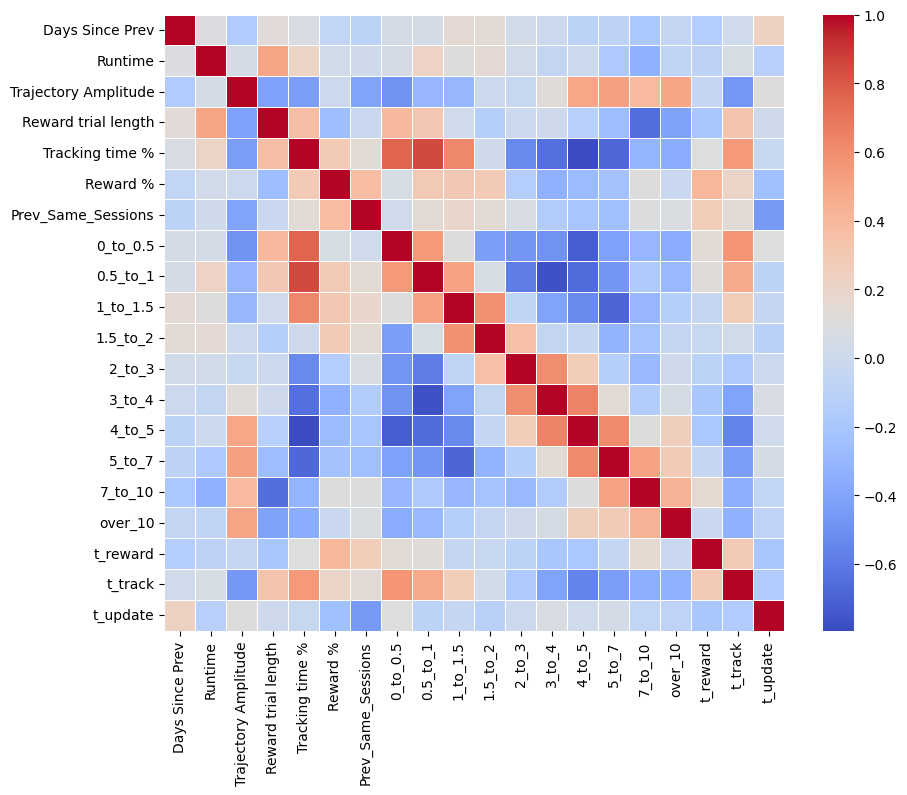

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = X[numeric_columns].corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)

plt.show()


Text(0.5, 1.0, 'Tracking time')

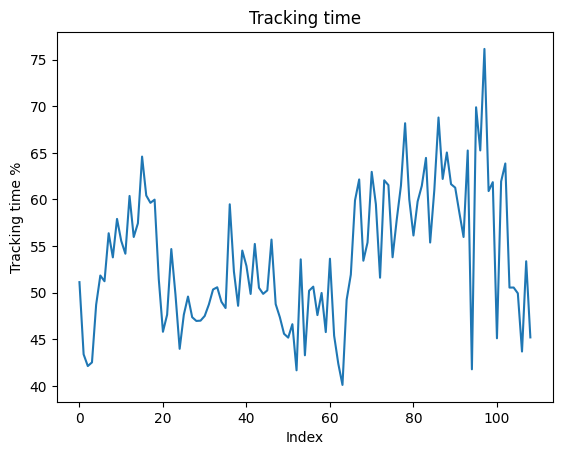

In [15]:
import matplotlib.pyplot as plt

plt.plot(X['Tracking time %'])
plt.xlabel('Index')
plt.ylabel('Tracking time %')
plt.title('Tracking time')

Text(0.5, 1.0, 'Rewards')

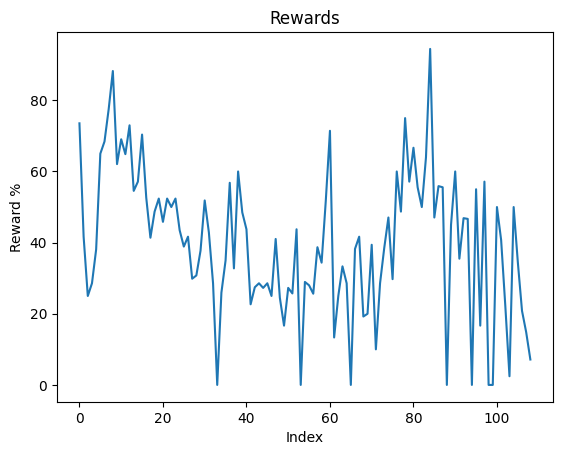

In [16]:
plt.plot(X['Reward %'])
plt.xlabel('Index')
plt.ylabel('Reward %')
plt.title('Rewards')

### Models

Random Chance RMSE: 31.57002465177629
Root Mean Squared Error: 10.698310422104885


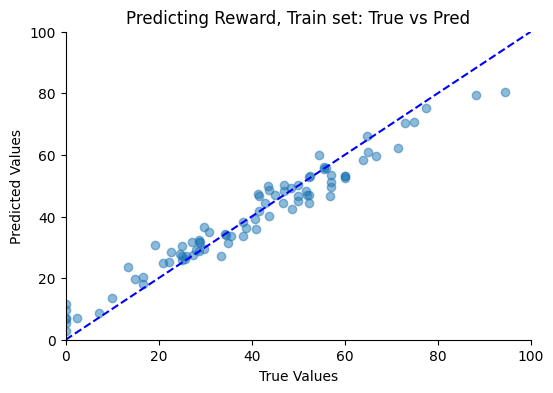

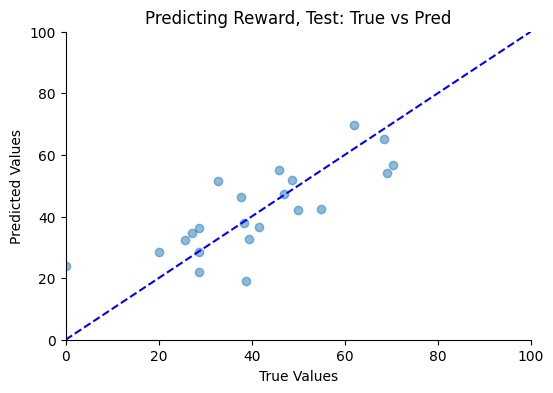

In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def build_dataset(X, y, test_size=0.2, random_state=143, use_difficulty=True):
    
    # drop the last row (this will have NaN values for targets)
    X = X.drop(X.index[-1])
    
    y = X[y] # get target
    
    # drop targets from features
    labels = X.filter(like='t_').columns if not use_difficulty else X.columns[X.columns.str.startswith('t_') & ~X.columns.str.endswith('t_update')]

    X_new = X.drop(columns=labels)
        
    # drop non helpful columns
    X_new = X_new.drop(columns=['File Name', 'Reward trial length', 'Trajectory Amplitude'])
    
    # split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test 


def predict(X_train, y_train, X_test, y_test):

    # random chance error

    y_pred_random = np.random.uniform(0, 100, size=y_test.shape)
    rmse_random = np.sqrt(mean_squared_error(y_test, y_pred_random))

    print(f"Random Chance RMSE: {rmse_random}")
    
    # build model

    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.15,
                    max_depth = 2, alpha = 10, n_estimators = 100)

    xg_reg.fit(X_train, y_train)

    y_pred = xg_reg.predict(X_test)
    
    # real error

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Root Mean Squared Error: {rmse}')
    
    return xg_reg

def eval_plot(train, train_y, title, xg_reg):
    y_pred = xg_reg.predict(train)

    plt.figure(figsize=(6, 4))
    plt.plot([0, 100], [0, 100], color='blue', linestyle='--')
    plt.scatter(train_y, y_pred, alpha=0.5)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    plt.show()
    
    
def build_and_predict(X, y, use_difficulty=True): 
    X_train, X_test, y_train, y_test = build_dataset(X, y, use_difficulty=use_difficulty)
    xg_reg = predict(X_train, y_train, X_test, y_test)
    
    label_type = y[2:].capitalize()
    
    eval_plot(X_train, y_train, "Predicting " + label_type + ", Train set: True vs Pred", xg_reg)
    eval_plot(X_test, y_test, "Predicting " + label_type + ", Test: True vs Pred", xg_reg)

    return xg_reg, X_train, X_test, y_train, y_test

xg_reg, X_train, X_test, y_train, y_test = build_and_predict(X, "t_reward")

In [35]:
# save model as pkl

import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(xg_reg, file)

In [36]:
# sample usage
with open('model_w_difficulty.pkl', 'rb') as file:
    model = pickle.load(file)
    
X_train = X_train.reset_index(drop=True)
print(f"Prediction: {model.predict(X_train.loc[[0]])}")
print(f"Actual: {y_train[0]}")

Prediction: [53.266838]
Actual: 41.66666666666667


In [37]:
def make_pred(prefix, model, difficulty=None):
    
    subj, subj_file_names_sorted = grab_files(show=False, prefix = prefix)
    subj2 = build_hdf_df(subj, subj_file_names_sorted)
    subj3 = build_trial_df_from_hdf_df(subj2)        

    X = add_hdf_summary_stats(subj2, subj3)

    X_row = X.iloc[[-1]]    
    X_row = X_row.drop(columns=['File Name', 'Reward trial length', 'Trajectory Amplitude'])
    
    if difficulty != None:
        X_row['t_update'] = difficulty
    
    pred = model.predict(X_row)
    
    return pred
    
make_pred('chur', model, 1)

112 files parsed.
chur20230202_08_te218.hdf
chur20231226_03_te443.hdf


array([33.82748], dtype=float32)

### Historically, when does difficulty increase?

In [18]:
X.t_update.value_counts()

t_update
0.0    77
1.0    31
Name: count, dtype: int64

#### Plotting

In [17]:
def plot_updates(variable):
    color_map = {1.0: 'red', 0.0: 'blue'}

    plt.figure(figsize=(10, 6))
    for t_update, group in X.groupby('t_update'):
        plt.scatter(group.index, group[variable], label=t_update, color=color_map[t_update])

    plt.title(f'{variable} by t_update')
    plt.xlabel('Index')
    plt.ylabel(variable)
    plt.legend(title='t_update', loc='upper left')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.show()

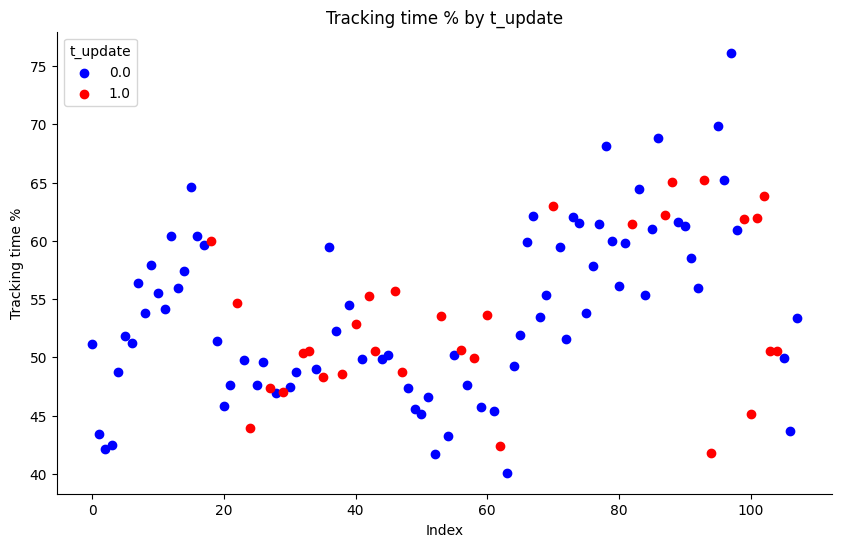

In [29]:
plot_updates('Tracking time %')

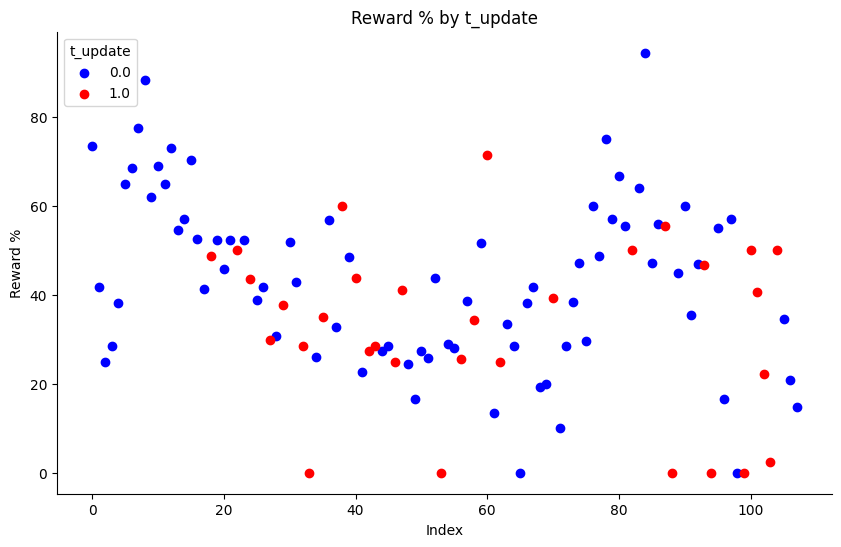

In [31]:
plot_updates('Reward %')

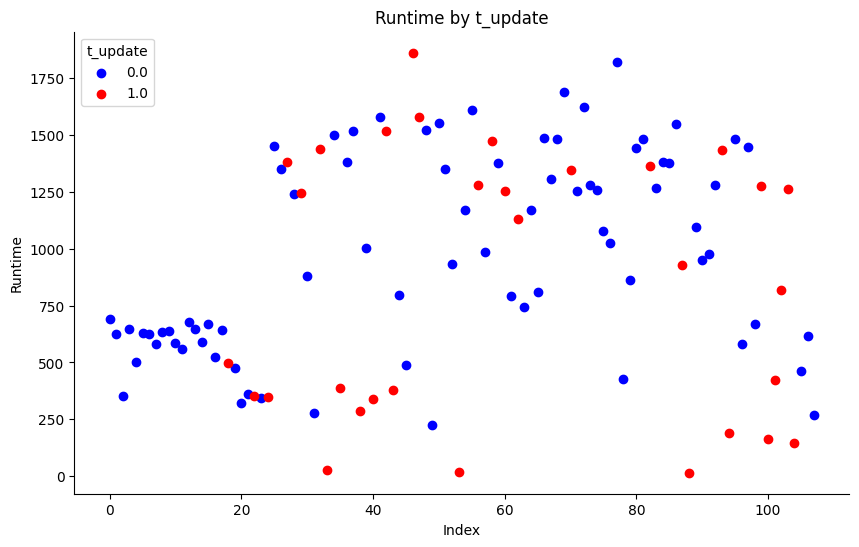

In [36]:
plot_updates('Runtime')

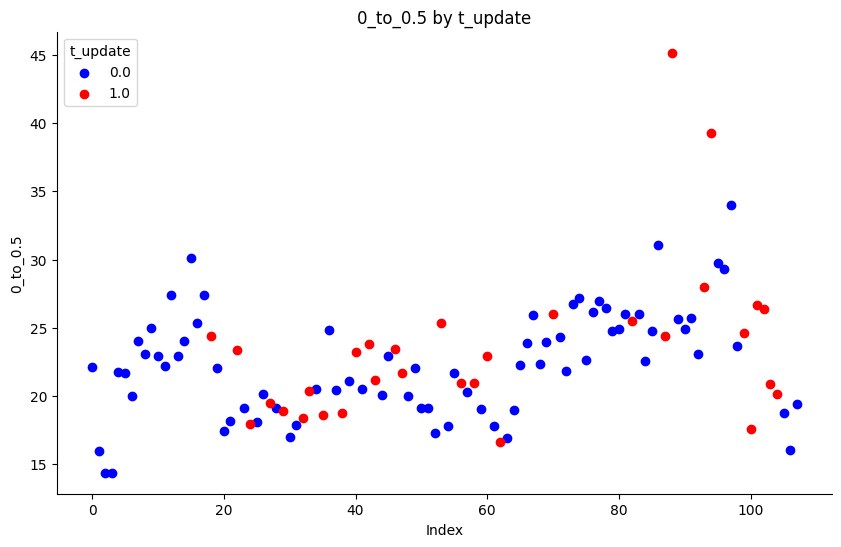

In [35]:
plot_updates('0_to_0.5')

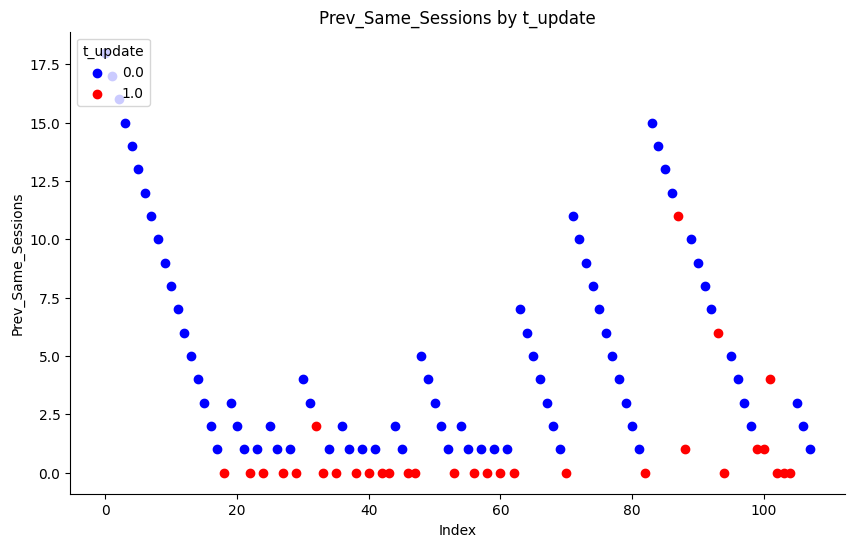

In [18]:
plot_updates('Prev_Same_Sessions')

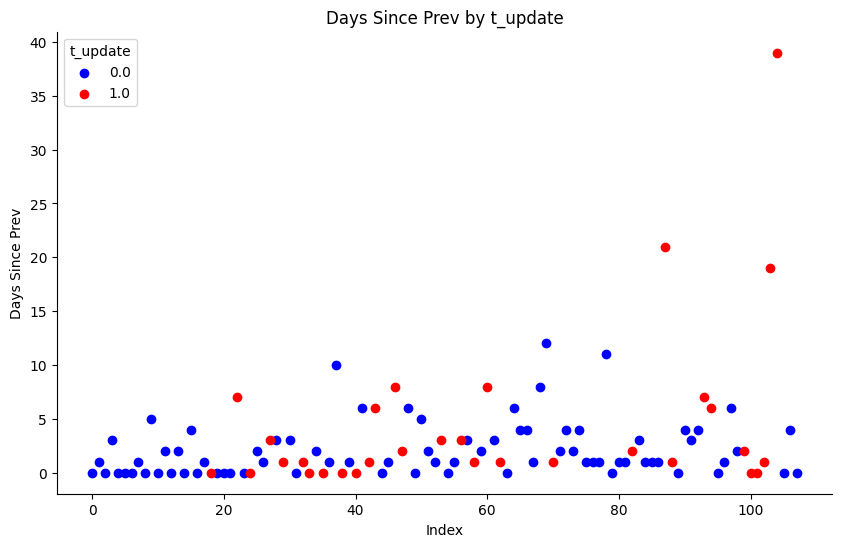

In [33]:
plot_updates('Days Since Prev')

#### Quantative Analysis